In [2]:
pip install -r requirements.txt

Note: you may need to restart the kernel to use updated packages.


Usage: __main__.py [options]

ERROR: Invalid requirement: python -m spacy download en_core_web_sm
__main__.py: error: no such option: -m


[notice] A new release of pip is available: 24.0 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [3]:
!pip install pandas numpy nltk spacy scikit-learn
!python -m spacy download en_core_web_sm


[notice] A new release of pip is available: 24.0 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


     ---------------------------------------- 0.0/12.8 MB ? eta -:--:--
     ---------------------------------------- 0.0/12.8 MB ? eta -:--:--
     --------------------------------------- 0.0/12.8 MB 445.2 kB/s eta 0:00:29
     --------------------------------------- 0.1/12.8 MB 880.9 kB/s eta 0:00:15
     - -------------------------------------- 0.4/12.8 MB 2.6 MB/s eta 0:00:05
     -- ------------------------------------- 0.7/12.8 MB 3.5 MB/s eta 0:00:04
     --- ------------------------------------ 1.2/12.8 MB 4.9 MB/s eta 0:00:03
     ---- ----------------------------------- 1.6/12.8 MB 5.6 MB/s eta 0:00:02
     ------- -------------------------------- 2.3/12.8 MB 6.8 MB/s eta 0:00:02
     -------- ------------------------------- 2.8/12.8 MB 7.4 MB/s eta 0:00:02
     ---------- ----------------------------- 3.5/12.8 MB 8.0 MB/s eta 0:00:02
     ------------ --------------------------- 3.9/12.8 MB 8.5 MB/s eta 0:00:02
     ------------ --------------------------- 3.9/12.8 MB 8.5 MB


[notice] A new release of pip is available: 24.0 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


Problem Statement 

Usually, hospitals billing team would sometime neglect the critical billing cases due to the close cost report deadlines. However, what if we can classify billing cases based on severities for the billing team prioritize and bill to not miss any important cases. In this experiment, I utilized a random forest classifier and bidirectional encoder to be able to learn and classify the data. 

In [3]:
import pandas as pd
import numpy as np
import nltk
import spacy
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, classification_report
from datetime import datetime
import openpyxl
%matplotlib inline
from sentence_transformers import SentenceTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from imblearn.over_sampling import SMOTE
#Import libraries 

In [15]:
from dotenv import load_dotenv
import os

load_dotenv()


True

In [ ]:
from dotenv import load_dotenv
import os
import pandas as pd

# Load .env from the project root (assuming you're in /src or a subfolder)
load_dotenv(dotenv_path=os.path.join(os.getcwd(), '..', '.env'))

# Get the relative path from .env
relative_path = os.getenv("DATA_PATH")

# Build full path from current working directory
data_path = os.path.abspath(os.path.join(os.getcwd(), '..', relative_path))

# Confirm and read
data = pd.read_csv(data_path)


Loading from: c:\Users\MHS\Desktop\PROJECTS\billing_priority\data\fake_patient_visits.csv


In [5]:
# Download NLTK VADER lexicon
nltk.download('vader_lexicon')
# Load SpaCy model
nlp = spacy.load("en_core_web_sm")


[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\MHS\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [13]:
data = pd.read_csv(data_path)

FileNotFoundError: [Errno 2] No such file or directory: 'data/fake_patient_visits.csv'

In [5]:
data.shape[0], data.shape[1]


(30, 7)

In [6]:
data.head(5)

,Date of Visit,Clinic Name,Patient ID,Date of Birth,Diagnosis Code,Diagnosis Description,Visit Reason
0,5/23/2025 4:00 PM,Midtown Family Care,597634,"Tuesday, June 13, 1989",F32.9,Major depressive disorder,Pain management consultation
1,5/4/2025 4:00 PM,Downtown Med Center,845777,"Wednesday, September 16, 1959",E11.9,Type 2 diabetes mellitus,Mental health screening
2,5/1/2025 1:00 PM,Wellness Center East,981289,"Tuesday, July 15, 1969",I10,Essential (primary) hypertension,Lab results review
3,5/2/2025 8:00 AM,Midtown Family Care,772980,"Tuesday, March 11, 1969",K21.9,Gastro-esophageal reflux disease,General health concerns
4,5/31/2025 1:00 PM,Downtown Med Center,825450,"Wednesday, December 06, 1989",Z00.00,General medical examination,Neurology referral


In [7]:
data.tail(5)

,Date of Visit,Clinic Name,Patient ID,Date of Birth,Diagnosis Code,Diagnosis Description,Visit Reason
25,5/20/2025 8:00 AM,Wellness Center East,513079,"Sunday, December 23, 1956",L40.0,Psoriasis vulgaris,Mental health screening
26,6/25/2025 10:00 AM,Wellness Center East,927351,"Thursday, June 05, 1969",I10,Essential (primary) hypertension,Medication adjustment
27,5/2/2025 10:00 AM,Primary Health Hub,868442,"Tuesday, May 13, 1986",R51,Headache,New patient intake
28,6/28/2025 4:00 PM,Primary Health Hub,804656,"Wednesday, July 14, 1965",N18.3,Chronic kidney disease stage 3,New patient intake
29,5/11/2025 4:00 PM,Downtown Med Center,546241,"Thursday, April 01, 2004",Z00.00,General medical examination,New patient intake


In [9]:
data = data.drop('Patient ID', axis=1)


In [10]:
data=data.dropna().reset_index(drop=True)

In [11]:
data['Date of Visit'] = pd.to_datetime(data['Date of Visit'])
data['Date of Birth'] = pd.to_datetime(data['Date of Birth'])


C:\Users\MHS\AppData\Local\Temp\ipykernel_22688\1775382026.py:1: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  data['Date of Visit'] = pd.to_datetime(data['Date of Visit'])


In [13]:
def preprocess_text(text):
    """Clean and lemmatize text using SpaCy."""
    if pd.isna(text):
        return ""
    doc = nlp(str(text).lower())
    tokens = [token.lemma_ for token in doc if not token.is_punct and not token.is_stop]
    return " ".join(tokens)

In [14]:
#Lemmatized the text
data['Diagnosis Description'] = data['Diagnosis Description'].apply(preprocess_text)

In [15]:
data['Visit Reason'] = data['Visit Reason'].apply(preprocess_text)

In [16]:
data

,Date of Visit,Clinic Name,Date of Birth,Diagnosis Code,Diagnosis Description,Visit Reason
0,2025-05-23 16:00:00,Midtown Family Care,1989-06-13,F32.9,major depressive disorder,pain management consultation
1,2025-05-04 16:00:00,Downtown Med Center,1959-09-16,E11.9,type 2 diabete mellitus,mental health screening
2,2025-05-01 13:00:00,Wellness Center East,1969-07-15,I10,essential primary hypertension,lab result review
3,2025-05-02 08:00:00,Midtown Family Care,1969-03-11,K21.9,gastro esophageal reflux disease,general health concern
4,2025-05-31 13:00:00,Downtown Med Center,1989-12-06,Z00.00,general medical examination,neurology referral
5,2025-06-21 10:00:00,Community Health NW,1979-07-14,F32.9,major depressive disorder,mental health screening
6,2025-06-09 08:00:00,Community Health NW,1957-08-25,I10,essential primary hypertension,dermatology check
7,2025-05-13 09:00:00,Wellness Center East,1997-07-15,L40.0,psoriasis vulgaris,pain management consultation
8,2025-05-26 12:00:00,Community Health NW,2005-01-26,J45.909,unspecified asthma uncomplicated,routine follow
9,2025-06-15 14:00:00,Primary Health Hub,1958-12-04,Z00.00,general medical examination,neurology referral


In [35]:
data['Clinic Name'].unique()

array(['Midtown Family Care', 'Downtown Med Center',
       'Wellness Center East', 'Community Health NW',
       'Primary Health Hub'], dtype=object)

In [19]:
data['Visit Reason'].unique()

array(['pain management consultation', 'mental health screening',
       'lab result review', 'general health concern',
       'neurology referral', 'dermatology check', 'routine follow',
       'annual physical exam', 'medication adjustment',
       'new patient intake'], dtype=object)

In [17]:
sid = SentimentIntensityAnalyzer()

In [18]:
#negative scores indicate urgency, position scores indicate non-urgency
data['narrative_sentiment'] = data['Diagnosis Description'].apply(
    lambda x: sid.polarity_scores(str(x))['compound'] if pd.notna(x) else 0
)

In [20]:
#negative scores indicate urgency, position scores indicate non-urgency
data['complaint_sentiment'] = data['Visit Reason'].apply(
    lambda x: sid.polarity_scores(str(x))['compound'] if pd.notna(x) else 0
)

In [21]:
def extract_entities(text):
    """Extract medical entities using SpaCy NER."""
    if pd.isna(text):
        return []
    doc = nlp(str(text))
    return [ent.text.lower() for ent in doc.ents if ent.label_ in ['DISEASE', 'SYMPTOM', 'MEDICATION']]

In [23]:
urgent_keywords = [
    'pain', 'fever', 'breath', 'sore throat', 'vomiting', 'diarrhea', 'chest', 
    'emergency', 'severe', 'chronic', 'malignant', 'sepsis', 'fracture'
]

In [24]:
def count_urgent_keywords(text):
    """Count occurrences of urgent keywords in text."""
    if pd.isna(text):
        return 0
    text = str(text).lower()
    return sum(text.count(keyword) for keyword in urgent_keywords)

In [25]:
data['urgent_keyword_count'] = (
    data['Diagnosis Description'].apply(count_urgent_keywords) + 
    data['Visit Reason'].apply(count_urgent_keywords)
)

In [26]:
data['Diagnosis Code'].unique()

array(['F32.9', 'E11.9', 'I10', 'K21.9', 'Z00.00', 'L40.0', 'J45.909',
       'N18.3', 'R51'], dtype=object)

In [28]:
icd_severity = {
    'F32.9': 4,   # Major depressive disorder, single episode, unspecified → Severe
    'E11.9': 3,   # Type 2 diabetes mellitus without complications → Moderate
    'I10': 3,     # Essential (primary) hypertension → Moderate
    'K21.9': 2,   # GERD without esophagitis → Mild to Moderate
    'Z00.00': 1,  # General medical exam without complaint → None/Mild
    'L40.0': 2,   # Psoriasis vulgaris → Mild to Moderate (can vary)
    'J45.909': 3, # Unspecified asthma, uncomplicated → Moderate (if controlled)
    'N18.3': 4,   # Chronic kidney disease stage 3 → Moderate to Severe
    'R51': 1      # Headache → Mild (unless chronic or underlying issue)
}


In [29]:
data['icd_severity'] = data['Diagnosis Code'].map(icd_severity).fillna(1)

In [31]:
date = data.sort_values(by='Date of Visit').loc[0, 'Date of Visit']

In [34]:

data['age'] = (pd.to_datetime(date) - data['Date of Birth']).dt.days // 365

In [36]:
data['priority'] = np.where(
    (data['icd_severity'] >= 3) |
    (data['urgent_keyword_count'] >= 2),
    1,
    0
)

In [37]:
data['length_of_narrative'] = data['Diagnosis Description'].fillna('').str.split().str.len()

In [38]:
data['VISIT_datetime'] = pd.to_datetime(data['Date of Visit'], format='%m/%d/%Y %I:%M:%S %p', errors='coerce')
data['time_of_day'] = data['VISIT_datetime'].dt.hour

In [41]:
data

,Date of Visit,Clinic Name,Date of Birth,Diagnosis Code,Diagnosis Description,Visit Reason,narrative_sentiment,complaint_sentiment,urgent_keyword_count,icd_severity,age,priority,length_of_narrative,VISIT_datetime,time_of_day
0,2025-05-23 16:00:00,Midtown Family Care,1989-06-13,F32.9,major depressive disorder,pain management consultation,-0.6486,-0.5106,1,4,35,1,3,2025-05-23 16:00:00,16
1,2025-05-04 16:00:00,Downtown Med Center,1959-09-16,E11.9,type 2 diabete mellitus,mental health screening,0.0000,0.0000,0,3,65,1,4,2025-05-04 16:00:00,16
2,2025-05-01 13:00:00,Wellness Center East,1969-07-15,I10,essential primary hypertension,lab result review,0.0000,0.0000,0,3,55,1,3,2025-05-01 13:00:00,13
3,2025-05-02 08:00:00,Midtown Family Care,1969-03-11,K21.9,gastro esophageal reflux disease,general health concern,0.0000,0.0000,0,2,56,0,4,2025-05-02 08:00:00,8
4,2025-05-31 13:00:00,Downtown Med Center,1989-12-06,Z00.00,general medical examination,neurology referral,0.0000,0.0000,0,1,35,0,3,2025-05-31 13:00:00,13
5,2025-06-21 10:00:00,Community Health NW,1979-07-14,F32.9,major depressive disorder,mental health screening,-0.6486,0.0000,0,4,45,1,3,2025-06-21 10:00:00,10
6,2025-06-09 08:00:00,Community Health NW,1957-08-25,I10,essential primary hypertension,dermatology check,0.0000,0.0000,0,3,67,1,3,2025-06-09 08:00:00,8
7,2025-05-13 09:00:00,Wellness Center East,1997-07-15,L40.0,psoriasis vulgaris,pain management consultation,0.0000,-0.5106,1,2,27,0,2,2025-05-13 09:00:00,9
8,2025-05-26 12:00:00,Community Health NW,2005-01-26,J45.909,unspecified asthma uncomplicated,routine follow,0.0000,0.0000,0,3,20,1,3,2025-05-26 12:00:00,12
9,2025-06-15 14:00:00,Primary Health Hub,1958-12-04,Z00.00,general medical examination,neurology referral,0.0000,0.0000,0,1,66,0,3,2025-06-15 14:00:00,14


In [43]:
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline

In [42]:
features = [
    'age',
    'narrative_sentiment',
    'complaint_sentiment',
    'length_of_narrative',
    'time_of_day',
    
]

In [44]:
X = data[features].fillna(0)
y = data['priority']

In [45]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [57]:
model = RandomForestClassifier(n_estimators=100, class_weight='balanced', random_state=42)

In [58]:
model.fit(X_train, y_train)

RandomForestClassifier(class_weight='balanced', random_state=42)

In [59]:
y_pred = model.predict(X_test)

In [60]:
print("Model Performance:")
print(classification_report(y_test, y_pred))

Model Performance:
              precision    recall  f1-score   support

           0       0.67      0.67      0.67         3
           1       0.67      0.67      0.67         3

    accuracy                           0.67         6
   macro avg       0.67      0.67      0.67         6
weighted avg       0.67      0.67      0.67         6



In [61]:
precision = precision_score(y_test, y_pred)
print(f"Precision for high-priority cases: {precision:.2f}")

Precision for high-priority cases: 0.67


In [52]:
print(data['priority'].value_counts(normalize=False))

priority
1    16
0    14
Name: count, dtype: int64


In [ ]:
from sklearn.model_selection import cross_val_score, LeaveOneOut
from sklearn.model_selection import StratifiedKFold

# Model: Use only age, narratto avoid leakage
def cross_validate(X, y, model):
    X = data[X].fillna(0)
    y = data['priority']
    if len(data) > 5:
        skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
        cv_scores = cross_val_score(model, X, y, cv=skf, scoring='f1', error_score=0)
        print(f"5-fold cross-validated F1: {cv_scores.mean():.2f} ± {cv_scores.std():.2f}")



In [ ]:
from xgboost import XGBClassifier
model = XGBClassifier(use_label_encoder=False, eval_metric='logloss', scale_pos_weight=1)



In [70]:
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred))
print(f"precison score:", precision_score(y_test, y_pred))


c:\Users\MHS\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\training.py:183: UserWarning: [18:47:04] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


              precision    recall  f1-score   support

           0       0.50      0.33      0.40         3
           1       0.50      0.67      0.57         3

    accuracy                           0.50         6
   macro avg       0.50      0.50      0.49         6
weighted avg       0.50      0.50      0.49         6

precison score: 0.5


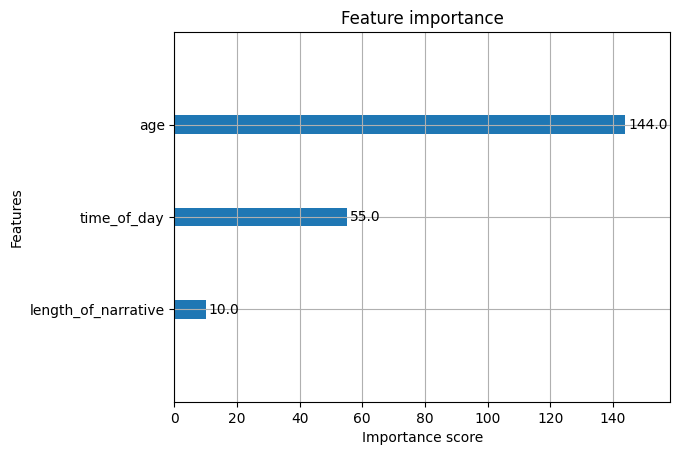

In [71]:
import matplotlib.pyplot as plt
from xgboost import plot_importance

plot_importance(model)
plt.show()

In [45]:
#Smote pipeline 
smote_pipeline = Pipeline([
    ('smote', SMOTE(random_state=42)),
    ('classifier', model)
])

In [46]:
smote_pipeline.fit(X_train, y_train)
y_pred_smote = smote_pipeline.predict(X_test)

In [47]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))
print("Accuracy:", accuracy_score(y_test, y_pred))

[[1344   66]
 [ 140  230]]
              precision    recall  f1-score   support

           0       0.91      0.95      0.93      1410
           1       0.78      0.62      0.69       370

    accuracy                           0.88      1780
   macro avg       0.84      0.79      0.81      1780
weighted avg       0.88      0.88      0.88      1780

Accuracy: 0.8842696629213483


In [2]:
bert_model = SentenceTransformer('all-MiniLM-L6-v2')  # Light and fast

# Combine and fill text fields
data['text'] = (data['Diagnosis Description'].fillna('') + ' ' +
                         data['Visit Reason'].fillna(''))

# Create BERT embeddings
bert_embeddings = bert_model.encode(data['text'].tolist(), show_progress_bar=True)


NameError: name 'SentenceTransformer' is not defined

In [49]:
X_numeric = data[features].fillna(0)
scaler = StandardScaler()
X_numeric_scaled = scaler.fit_transform(X_numeric)

In [50]:
X_combined = np.hstack([bert_embeddings, X_numeric_scaled])

# ----------------------
# Step 4: Train/Test Split
# ----------------------
X_train, X_test, y_train, y_test = train_test_split(X_combined, y, stratify=y, random_state=42)

# ----------------------
# Step 5: Apply SMOTE
# ----------------------
smote = SMOTE(random_state=42)
X_train_res, y_train_res = smote.fit_resample(X_train, y_train)

# ----------------------
# Step 6: Train Classifier
# ----------------------
clf = RandomForestClassifier(random_state=42)
clf.fit(X_train_res, y_train_res)

# ----------------------
# Step 7: Evaluate
# ----------------------
y_pred = clf.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.96      0.96      0.96      1790
           1       0.82      0.85      0.84       435

    accuracy                           0.93      2225
   macro avg       0.89      0.90      0.90      2225
weighted avg       0.94      0.93      0.94      2225



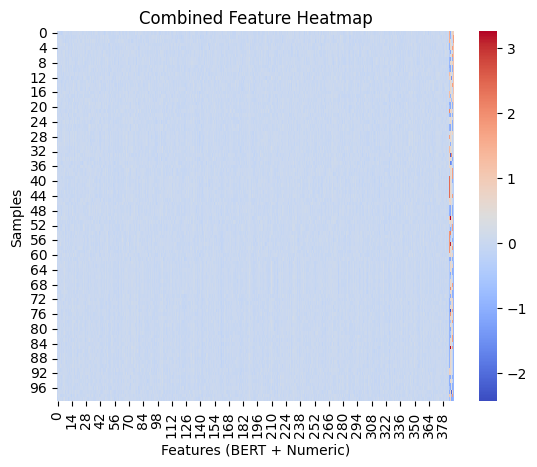

In [61]:
import matplotlib.pyplot as plt
import seaborn as sns

# Show the first 100 samples for visualization
sns.heatmap(X_combined[:100], cmap="coolwarm", cbar=True)
plt.title("Combined Feature Heatmap")
plt.xlabel("Features (BERT + Numeric)")
plt.ylabel("Samples")
plt.show()

In [51]:
# Get predicted probabilities
y_probs = clf.predict_proba(X_test)[:, 1]  # probability for class 1

# Change threshold (default is 0.5)
threshold = 0.3  # Lower means more positive predictions
y_pred_thresh = (y_probs >= threshold).astype(int)

# Re-evaluate
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred_thresh))


              precision    recall  f1-score   support

           0       1.00      0.83      0.90      1790
           1       0.58      0.99      0.73       435

    accuracy                           0.86      2225
   macro avg       0.79      0.91      0.82      2225
weighted avg       0.92      0.86      0.87      2225



In [52]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5]
}

grid = GridSearchCV(RandomForestClassifier(random_state=42),
                    param_grid,
                    scoring='f1_macro',
                    cv=3)
grid.fit(X_train_res, y_train_res)

print("Best params:", grid.best_params_)
print("Best F1 Score:", grid.best_score_)


Best params: {'max_depth': None, 'min_samples_split': 2, 'n_estimators': 200}
Best F1 Score: 0.9620802658742206


In [53]:
best_rf = grid.best_estimator_

In [54]:
best_rf

RandomForestClassifier(n_estimators=200, random_state=42)

In [58]:
from sklearn.metrics import classification_report

y_test_pred = best_rf.predict(X_test)
print(classification_report(y_test, y_test_pred))


              precision    recall  f1-score   support

           0       0.96      0.96      0.96      1790
           1       0.83      0.85      0.84       435

    accuracy                           0.94      2225
   macro avg       0.90      0.90      0.90      2225
weighted avg       0.94      0.94      0.94      2225



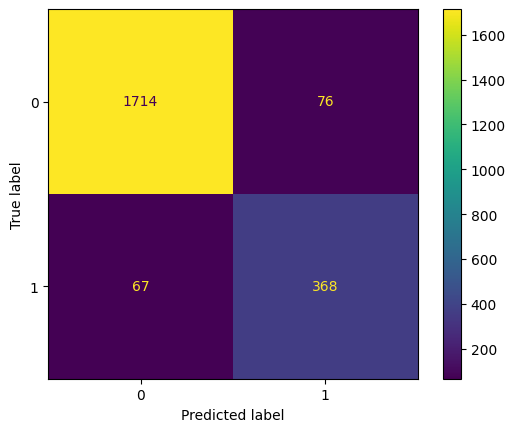

In [59]:
from sklearn.metrics import ConfusionMatrixDisplay

ConfusionMatrixDisplay.from_estimator(best_rf, X_test, y_test)


In [68]:
import pandas as pd

results_df = pd.DataFrame(grid.cv_results_)
results_df[['params', 'mean_test_score']].sort_values(by='mean_test_score', ascending=False)


,params,mean_test_score
1,"{'max_depth': None, 'min_samples_split': 2, 'n...",0.962080
2,"{'max_depth': None, 'min_samples_split': 5, 'n...",0.959936
3,"{'max_depth': None, 'min_samples_split': 5, 'n...",0.959844
11,"{'max_depth': 20, 'min_samples_split': 5, 'n_e...",0.959467
0,"{'max_depth': None, 'min_samples_split': 2, 'n...",0.958910
9,"{'max_depth': 20, 'min_samples_split': 2, 'n_e...",0.958347
10,"{'max_depth': 20, 'min_samples_split': 5, 'n_e...",0.957699
8,"{'max_depth': 20, 'min_samples_split': 2, 'n_e...",0.957227
5,"{'max_depth': 10, 'min_samples_split': 2, 'n_e...",0.946846
7,"{'max_depth': 10, 'min_samples_split': 5, 'n_e...",0.946473


In [71]:
final_model = RandomForestClassifier(**grid.best_params_, random_state=42)
final_model.fit(X_combined, y)  # Full dataset

RandomForestClassifier(n_estimators=200, random_state=42)